In [1]:
import os
os.chdir("../")
%pwd

'c:\\Users\\karthikeya\\Fraud_Detection'

In [2]:
from abc import abstractmethod, ABC

from sklearn.base import  ClassifierMixin

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

In [4]:
df = pd.read_parquet('artifacts/transformed_train_data.parquet')

In [5]:
df.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'errorbalanceOrig', 'errorbalanceDest'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4720458 entries, 1888243 to 1692743
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   amount            float64
 1   oldbalanceOrg     float64
 2   newbalanceOrig    float64
 3   oldbalanceDest    float64
 4   newbalanceDest    float64
 5   isFraud           float64
 6   errorbalanceOrig  float64
 7   errorbalanceDest  float64
dtypes: float64(8)
memory usage: 324.1 MB


In [7]:
df.reset_index(drop=True, inplace=True)
df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorbalanceOrig,errorbalanceDest
0,212458.78,234635.00,447093.78,806037.88,593579.10,0.0,424917.56,4.249176e+05
1,19967.60,3634.00,0.00,0.00,0.00,0.0,16333.60,1.996760e+04
2,527616.51,180216.00,0.00,92157.10,619773.61,0.0,347400.51,0.000000e+00
3,206067.85,0.00,0.00,2131494.48,2337562.32,0.0,206067.85,1.000000e-02
4,141.42,174.00,32.58,0.00,0.00,0.0,0.00,1.414200e+02
...,...,...,...,...,...,...,...,...
4720453,129715.85,5054252.83,5183968.68,246692.94,116977.09,0.0,259431.70,2.594317e+05
4720454,2459.70,0.00,0.00,0.00,0.00,0.0,2459.70,2.459700e+03
4720455,10579.16,59279.00,48699.84,322754.16,333333.32,0.0,0.00,-5.820766e-11
4720456,73020.76,20289.00,0.00,256102.84,329123.61,0.0,52731.76,-1.000000e-02


In [8]:
X = df.copy(deep=True)

X_n = X[X['isFraud']==0]
X_f = X[X['isFraud']==1]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
y_n = X_n['isFraud']
y_f = X_f['isFraud']

X_n = X_n.drop(columns=['isFraud'], axis=1)
X_f = X_f.drop(columns=['isFraud'], axis=1)
# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform non-fraudulent data
X_n_normalized = scaler.fit_transform(X_n)

# Transform fraudulent data using the same scaler
X_f_normalized = scaler.transform(X_f)

# Convert back to a DataFrame (optional, for better readability)
X_n_normalized = pd.DataFrame(X_n_normalized, columns=X_n.columns, index=X_n.index)
X_f_normalized = pd.DataFrame(X_f_normalized, columns=X_f.columns, index=X_f.index)



In [83]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the Attention Mechanism
class FeatureAttention(nn.Module):
    def __init__(self, input_dim):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Linear(input_dim, input_dim)  # Learnable weights for attention
        self.softmax = nn.Softmax(dim=1)  # Normalize across features

    def forward(self, x):
        attention_scores = self.softmax(self.attention(x))  # Compute attention scores
        attended_x = x * attention_scores  # Scale input by attention scores
        return attended_x, attention_scores

# Define the Autoencoder with Attention
class AttentionAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(AttentionAutoencoder, self).__init__()
        self.input_dim = input_dim

        # Attention mechanism
        self.attention = FeatureAttention(input_dim)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()  # Use Sigmoid if inputs are normalized to [0, 1]
        )

    def forward(self, x):
        # Apply attention mechanism
        attended_x, attention_scores = self.attention(x)

        # Encode and Decode
        encoded = self.encoder(attended_x)
        reconstructed = self.decoder(encoded)

        return reconstructed, attention_scores  # Return reconstructed input and attention weights

# Example Training Loop
def train_autoencoder(autoencoder, dataloader, epochs=5, learning_rate=1e-3):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # Reconstruction error

    autoencoder.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            inputs = batch[0]  # Data from DataLoader is already on the CPU
            optimizer.zero_grad()

            # Forward pass
            outputs, attention_scores = autoencoder(inputs)

            # Compute loss
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.6f}")


input_dim = X_n_normalized.shape[1]  # Number of features
dataset = TensorDataset(torch.tensor(X_n_normalized.values, dtype=torch.float32))

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)  # Use 8 CPU cores

# Initialize and Train the Autoencoder on CPU
feature_attention_autoencoder = AttentionAutoencoder(input_dim=input_dim)
train_autoencoder(feature_attention_autoencoder, dataloader, epochs=5)


Epoch [1/5], Loss: 0.000605
Epoch [2/5], Loss: 0.000015
Epoch [3/5], Loss: 0.000012
Epoch [4/5], Loss: 0.000011
Epoch [5/5], Loss: 0.000010


In [88]:
# Initialize the model
# feature_attention_autoencoder = AttentionAutoencoder(input_dim=input_dim)

# Calculate model size in parameters
model_size = sum(p.numel() for p in feature_attention_autoencoder.parameters())  # Total number of parameters
print(f"Model size: {model_size} parameters")


Model size: 632 parameters


In [89]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
import pandas as pd  # Ensure pandas is imported

# Function to calculate reconstruction loss for each data point
def calculate_reconstruction_loss_per_point(autoencoder, data):
    autoencoder.eval()  # Set model to evaluation mode
    data = torch.tensor(data.values, dtype=torch.float32)  # Convert data to tensor and ensure it's on CPU

    # Forward pass to get the reconstruction
    with torch.no_grad():  # No need to compute gradients for evaluation
        output = autoencoder(data)  # Ensure model and data are on the same device (CPU)
        # Handle cases where autoencoder returns multiple outputs (e.g., with attention scores)
        reconstructed = output[0] if isinstance(output, tuple) else output

    # Calculate the per-point reconstruction loss
    reconstruction_losses = F.mse_loss(reconstructed, data, reduction='none')  # Keep loss per data point
    reconstruction_losses = reconstruction_losses.mean(dim=1)  # Average over features for each data point

    return reconstruction_losses.numpy()  # Convert to numpy array for further processing

# Step 1: Calculate reconstruction loss for non-fraudulent data (X_n_normalized)
non_fraud_losses = calculate_reconstruction_loss_per_point(feature_attention_autoencoder, X_n_normalized)

# Step 2: Determine anomaly threshold using non-fraudulent data (e.g., 95th percentile)
threshold = np.percentile(non_fraud_losses, 99)  # 95% threshold
print(f"Anomaly Threshold: {threshold:.6f}")

# Step 3: Calculate reconstruction loss for fraudulent data (X_f_normalized)
fraud_losses = calculate_reconstruction_loss_per_point(feature_attention_autoencoder, X_f_normalized)
print("Reconstruction Loss for Fraudulent Data Points:")
print(fraud_losses)

# Step 4: Classify fraudulent and non-fraudulent data based on the threshold
# Combine X_n_normalized and X_f_normalized for predictions using pd.concat
all_data = pd.concat([X_n_normalized, X_f_normalized], axis=0)  # Concatenate data along rows (axis=0)
all_losses = calculate_reconstruction_loss_per_point(feature_attention_autoencoder, all_data)

# Predict anomalies (True if reconstruction loss exceeds threshold)
predicted_anomalies = all_losses > threshold

# Step 5: Generate ground truth labels for combined data
# Non-fraudulent data (X_n_normalized) has label 0, Fraudulent data (X_f_normalized) has label 1
true_labels = np.concatenate([np.zeros(len(X_n_normalized)), np.ones(len(X_f_normalized))])

# Step 6: Calculate F1-score
f1 = f1_score(true_labels, predicted_anomalies)
precision = precision_score(true_labels, predicted_anomalies)
recall = recall_score(true_labels, predicted_anomalies)
print(f"F1-Score: {f1:.6f}")
print(f"precision: {precision:.6f}")
print(f"recall: {recall:.6f}")



Anomaly Threshold: 0.000054
Reconstruction Loss for Fraudulent Data Points:
[3.4217339e-04 8.4352050e-06 1.4093400e-06 ... 1.7983959e-05 3.3805841e-06
 6.9579808e-05]
F1-Score: 0.174662
precision: 0.110460
recall: 0.417076


In [12]:
X_n_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4714356 entries, 0 to 4720457
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   amount            float64
 1   oldbalanceOrg     float64
 2   newbalanceOrig    float64
 3   oldbalanceDest    float64
 4   newbalanceDest    float64
 5   isFraud           float64
 6   errorbalanceOrig  float64
 7   errorbalanceDest  float64
dtypes: float64(8)
memory usage: 323.7 MB


In [14]:
X_n_normalized.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorbalanceOrig,errorbalanceDest
count,4.714356e+06,4.714356e+06,4.714356e+06,4.714356e+06,4.714356e+06,4.714356e+06,4.714356e+06
mean,1.926516e-03,1.900326e-02,1.959094e-02,3.091039e-03,3.435932e-03,2.177052e-03,8.525266e-01
std,6.417486e-03,6.586442e-02,6.693015e-02,9.557606e-03,1.031787e-02,6.534129e-03,4.901491e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.446864e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.292491e-05,8.519119e-01
50%,8.079849e-04,3.204282e-04,0.000000e+00,3.742868e-04,6.025100e-04,7.470679e-04,8.519512e-01
75%,2.253467e-03,2.441666e-03,3.314162e-03,2.647042e-03,3.117477e-03,2.703871e-03,8.522406e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


C:\Users\karthikeya\AppData\Local\Temp\ipykernel_11528\4010283839.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\karthikeya\Fraud_Detection\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\karthikeya\AppData\Local\Temp\ipykernel_11528\4010283839.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\karthikeya\AppData\Local\Temp\ipykernel_11528\4010283839.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Train Loss: 0.092839, Validation Loss: 0.084317
Epoch [2/50], Train Loss: 0.084022, Validation Loss: 0.083890
Epoch [3/50], Train Loss: 0.084021, Validation Loss: 0.083741
Epoch [4/50], Train Loss: 0.084019, Validation Loss: 0.084086
Epoch [5/50], Train Loss: 0.084017, Validation Loss: 0.083680
Epoch [6/50], Train Loss: 0.084017, Validation Loss: 0.083743
Epoch [7/50], Train Loss: 0.084018, Validation Loss: 0.083816
Epoch [8/50], Train Loss: 0.084014, Validation Loss: 0.084158
Epoch [9/50], Train Loss: 0.084013, Validation Loss: 0.086738
Epoch [10/50], Train Loss: 0.084007, Validation Loss: 0.083925
Epoch [11/50], Train Loss: 0.084009, Validation Loss: 0.084895
Epoch [12/50], Train Loss: 0.084007, Validation Loss: 0.084016
Epoch [13/50], Train Loss: 0.084007, Validation Loss: 0.084406
Epoch [14/50], Train Loss: 0.084000, Validation Loss: 0.083682
Epoch [15/50], Train Loss: 0.084002, Validation Loss: 0.083787
Early stopping triggered after 15 epochs


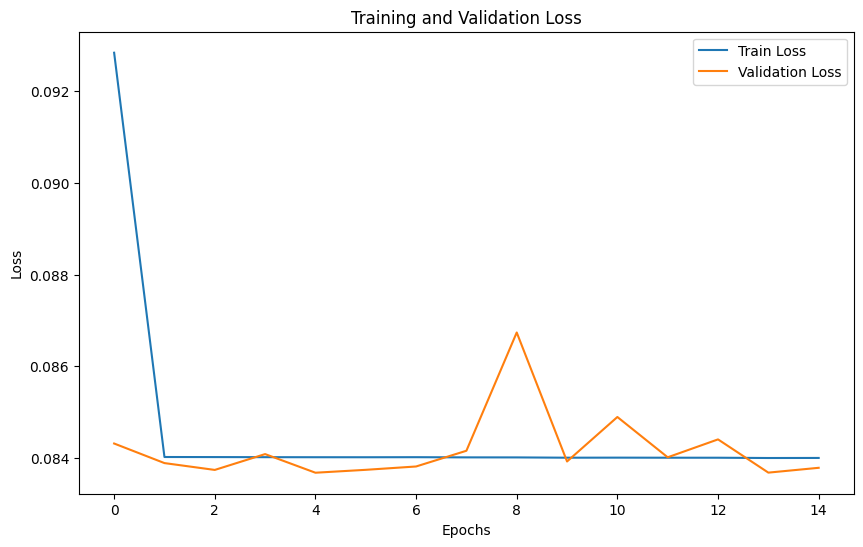

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

class VanillaAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(VanillaAutoencoder, self).__init__()
        self.input_dim = input_dim

        # Encoder with dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 6),
            nn.BatchNorm1d(6),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(6, 2),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(0.2)
        )

        # Decoder with dropout
        self.decoder = nn.Sequential(
            nn.Linear(2, 6),
            nn.BatchNorm1d(6),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(6, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

def train_vanilla_autoencoder(autoencoder, train_loader, val_loader, epochs=50, learning_rate=1e-3, patience=10):
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        autoencoder.train()
        total_train_loss = 0.0

        for batch_tuple in train_loader:
            inputs = batch_tuple[0]
            optimizer.zero_grad()
            
            # Use autocast for mixed precision
            with autocast():
                outputs = autoencoder(inputs)
                loss = criterion(outputs, inputs)
            
            # Scale loss and backprop
            scaler.scale(loss).backward()
            
            # Step optimizer and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        autoencoder.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_tuple in val_loader:
                inputs = batch_tuple[0]
                with autocast():
                    outputs = autoencoder(inputs)
                    loss = criterion(outputs, inputs)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

        # Step the scheduler with the validation loss
        scheduler.step(avg_val_loss)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break
    return train_losses, val_losses


def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage
input_dim = X_n_normalized.shape[1]
data_tensor = torch.tensor(X_n_normalized.to_numpy(), dtype=torch.float32)

# Create proper dataset
dataset = TensorDataset(data_tensor)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Initialize and train
device = torch.device("cpu")
vanilla_autoencoder = VanillaAutoencoder(input_dim=input_dim).to(device)
train_losses, val_losses = train_vanilla_autoencoder(vanilla_autoencoder, train_loader, val_loader)

# Plot losses
plot_loss(train_losses, val_losses)

In [26]:
import torch.nn.functional as F

# Function to calculate reconstruction loss for fraudulent data
def calculate_reconstruction_loss(autoencoder, data):
    autoencoder.eval()  # Set model to evaluation mode
    data = torch.tensor(data.values, dtype=torch.float32)  # Convert data to tensor and ensure it's on CPU
    
    # Forward pass to get the reconstruction
    with torch.no_grad():  # No need to compute gradients for evaluation
        output = autoencoder(data)  # Ensure model and data are on the same device (CPU)
        # Handle cases where autoencoder returns multiple outputs (e.g., with attention scores)
        reconstructed = output[0] if isinstance(output, tuple) else output
    
    # Calculate the reconstruction loss (MSE between input and reconstructed output)
    loss = F.mse_loss(reconstructed, data)
    return loss.item()

# Assuming you have your fraudulent data normalized (X_f_normalized)
# Calculate reconstruction loss for fraudulent data
fraud_loss = calculate_reconstruction_loss(vanilla_autoencoder, X_f_normalized)
print(f"Reconstruction Loss for vanilla_autoencoder for Fraudulent Data: {fraud_loss:.6f}")


Reconstruction Loss for vanilla_autoencoder for Fraudulent Data: 0.000969


In [27]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
import pandas as pd  # Ensure pandas is imported

# Function to calculate reconstruction loss for each data point
def calculate_reconstruction_loss_per_point(autoencoder, data):
    autoencoder.eval()  # Set model to evaluation mode
    data = torch.tensor(data.values, dtype=torch.float32)  # Convert data to tensor and ensure it's on CPU

    # Forward pass to get the reconstruction
    with torch.no_grad():  # No need to compute gradients for evaluation
        output = autoencoder(data)  # Ensure model and data are on the same device (CPU)
        # Handle cases where autoencoder returns multiple outputs (e.g., with attention scores)
        reconstructed = output[0] if isinstance(output, tuple) else output

    # Calculate the per-point reconstruction loss
    reconstruction_losses = F.mse_loss(reconstructed, data, reduction='none')  # Keep loss per data point
    reconstruction_losses = reconstruction_losses.mean(dim=1)  # Average over features for each data point

    return reconstruction_losses.numpy()  # Convert to numpy array for further processing

# Step 1: Calculate reconstruction loss for non-fraudulent data (X_n_normalized)
non_fraud_losses = calculate_reconstruction_loss_per_point(vanilla_autoencoder, X_n_normalized)

# Step 2: Determine anomaly threshold using non-fraudulent data (e.g., 95th percentile)
threshold = np.percentile(non_fraud_losses, 99.5)  # 95% threshold
print(f"Anomaly Threshold: {threshold:.6f}")

# Step 3: Calculate reconstruction loss for fraudulent data (X_f_normalized)
fraud_losses = calculate_reconstruction_loss_per_point(vanilla_autoencoder, X_f_normalized)
print("Reconstruction Loss for Fraudulent Data Points:")
print(fraud_losses)

# Step 4: Classify fraudulent and non-fraudulent data based on the threshold
# Combine X_n_normalized and X_f_normalized for predictions using pd.concat
all_data = pd.concat([X_n_normalized, X_f_normalized], axis=0)  # Concatenate data along rows (axis=0)
all_losses = calculate_reconstruction_loss_per_point(vanilla_autoencoder, all_data)

# Predict anomalies (True if reconstruction loss exceeds threshold)
predicted_anomalies = all_losses > threshold

# Step 5: Generate ground truth labels for combined data
# Non-fraudulent data (X_n_normalized) has label 0, Fraudulent data (X_f_normalized) has label 1
true_labels = np.concatenate([np.zeros(len(X_n_normalized)), np.ones(len(X_f_normalized))])

# Step 6: Calculate F1-score
# Step 6: Calculate F1-score
f1 = f1_score(true_labels, predicted_anomalies)
precision = precision_score(true_labels, predicted_anomalies)
recall = recall_score(true_labels, predicted_anomalies)
print(f"F1-Score: {f1:.6f}")
print(f"precision: {precision:.6f}")
print(f"recall: {recall:.6f}")



Anomaly Threshold: 0.000831
Reconstruction Loss for Fraudulent Data Points:
[5.5918429e-04 6.4929295e-06 1.1022464e-06 ... 1.5257358e-05 7.1520572e-07
 8.7494707e-05]
F1-Score: 0.073117
precision: 0.045591
recall: 0.184530


Epoch [1/5], Train Loss: 0.042848, Validation Loss: 0.042821
Epoch [2/5], Train Loss: 0.042719, Validation Loss: 0.042824
Epoch [3/5], Train Loss: 0.042687, Validation Loss: 0.042804
Epoch [4/5], Train Loss: 0.042628, Validation Loss: 0.042825
Epoch [5/5], Train Loss: 0.042628, Validation Loss: 0.042832


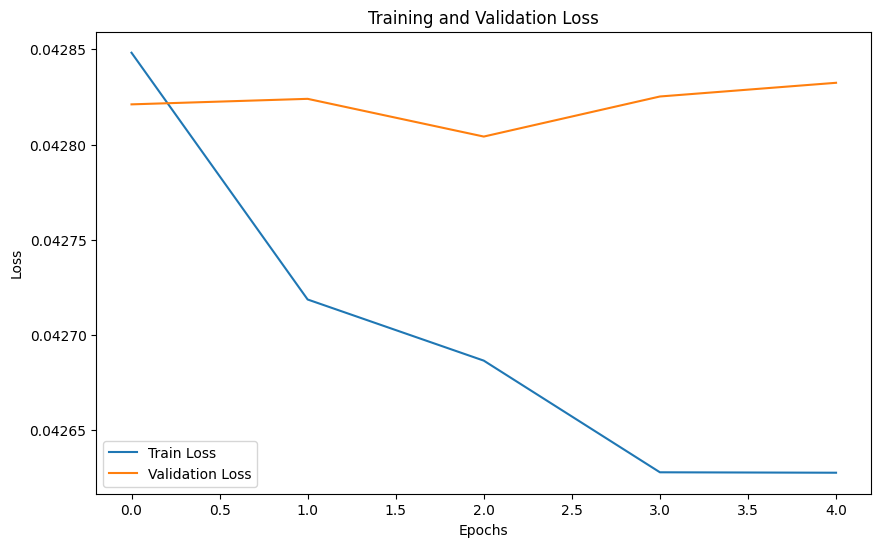

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.1),
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(8, latent_dim)
        self.fc_var = nn.Linear(8, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.LeakyReLU(0.1),
            nn.Linear(8, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        log_var = self.fc_var(hidden)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def vae_loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (binary cross entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

def train_vae(vae, train_loader, val_loader, epochs=5, learning_rate=1e-3):
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        vae.train()
        total_train_loss = 0.0
        
        for batch in train_loader:
            inputs = batch[0]
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, log_var = vae(inputs)
            
            # Calculate loss
            loss = vae_loss_function(recon_batch, inputs, mu, log_var)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        vae.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0]
                recon_batch, mu, log_var = vae(inputs)
                loss = vae_loss_function(recon_batch, inputs, mu, log_var)
                total_val_loss += loss.item()
                
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Adjust learning rate
        scheduler.step(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")
    
    return train_losses, val_losses

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage
# Assuming X_n_normalized is your normalized dataset
input_dim = X_n_normalized.shape[1]
data_tensor = torch.tensor(X_n_normalized.to_numpy(), dtype=torch.float32)

# Split dataset
train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_dataset, val_dataset = random_split(data_tensor, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Initialize and train the VAE
device = torch.device("cpu")
vae = VariationalAutoencoder(input_dim=input_dim).to(device)
train_losses, val_losses = train_vae(vae, train_loader, val_loader, epochs=5)

# Plot losses
plot_loss(train_losses, val_losses)

Epoch [1/10], Train Loss: 0.013263, Validation Loss: 0.009089
Epoch [2/10], Train Loss: 0.009148, Validation Loss: 0.009081
Epoch [3/10], Train Loss: 0.009151, Validation Loss: 0.009109
Epoch [4/10], Train Loss: 0.009146, Validation Loss: 0.009093
Epoch [5/10], Train Loss: 0.009149, Validation Loss: 0.009079
Epoch [6/10], Train Loss: 0.009153, Validation Loss: 0.009079
Epoch [7/10], Train Loss: 0.009148, Validation Loss: 0.009079
Epoch [8/10], Train Loss: 0.009143, Validation Loss: 0.009087
Epoch [9/10], Train Loss: 0.009141, Validation Loss: 0.009097
Epoch [10/10], Train Loss: 0.009155, Validation Loss: 0.009097


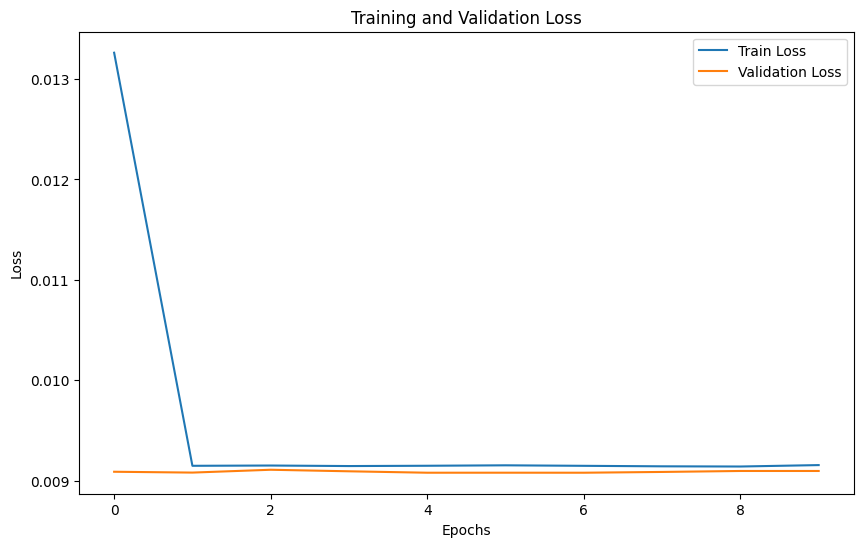

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(ImprovedVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder with batch normalization and dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        
        # Mean and variance layers with batch norm
        self.fc_mu = nn.Sequential(
            nn.Linear(16, latent_dim),
            nn.BatchNorm1d(latent_dim)
        )
        
        self.fc_var = nn.Sequential(
            nn.Linear(16, latent_dim),
            nn.BatchNorm1d(latent_dim)
        )
        
        # Decoder with batch normalization and dropout
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            
            nn.Linear(32, input_dim)
        )
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        log_var = self.fc_var(hidden)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class VAELoss(nn.Module):
    def __init__(self, reconstruction_weight=1.0, kl_weight=0.1):
        super(VAELoss, self).__init__()
        self.reconstruction_weight = reconstruction_weight
        self.kl_weight = kl_weight
        self.mse_loss = nn.MSELoss(reduction='sum')
    
    def forward(self, recon_x, x, mu, log_var):
        MSE = self.mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reconstruction_weight * MSE + self.kl_weight * KLD

def train_improved_vae(vae, train_loader, val_loader, epochs=10, learning_rate=1e-3):
    optimizer = optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = VAELoss(reconstruction_weight=1.0, kl_weight=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=2, T_mult=2, eta_min=1e-6
    )
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        vae.train()
        total_train_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            data = batch[0]
            # Ensure data has correct shape [batch_size, features]
            if len(data.shape) == 1:
                data = data.unsqueeze(0)
                
            optimizer.zero_grad()
            recon_batch, mu, log_var = vae(data)
            loss = criterion(recon_batch, data, mu, log_var)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        vae.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                data = batch[0]
                if len(data.shape) == 1:
                    data = data.unsqueeze(0)
                    
                recon_batch, mu, log_var = vae(data)
                loss = criterion(recon_batch, data, mu, log_var)
                total_val_loss += loss.item()
                
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")
    
    return train_losses, val_losses

# Example usage with proper data preparation
def prepare_data(X_n_normalized):
    # Convert to tensor if not already
    if not isinstance(X_n_normalized, torch.Tensor):
        data_tensor = torch.tensor(X_n_normalized.to_numpy(), dtype=torch.float32)
    else:
        data_tensor = X_n_normalized
        
    # Create dataset
    dataset = TensorDataset(data_tensor)
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create DataLoaders with proper batch handling
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=False,
        num_workers=8
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        drop_last=False,
        num_workers=8
    )
    
    return train_loader, val_loader

# Main execution
input_dim = X_n_normalized.shape[1]
train_loader, val_loader = prepare_data(X_n_normalized)

device = torch.device("cpu")
vae = ImprovedVAE(input_dim=input_dim).to(device)
train_losses, val_losses = train_improved_vae(vae, train_loader, val_loader, epochs=10)

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
x= df.copy(deep=True)

In [ ]:
x

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorbalanceOrig,errorbalanceDest
0,212458.78,234635.00,447093.78,806037.88,593579.10,0.0,424917.56,4.249176e+05
1,19967.60,3634.00,0.00,0.00,0.00,0.0,16333.60,1.996760e+04
2,527616.51,180216.00,0.00,92157.10,619773.61,0.0,347400.51,0.000000e+00
3,206067.85,0.00,0.00,2131494.48,2337562.32,0.0,206067.85,1.000000e-02
4,141.42,174.00,32.58,0.00,0.00,0.0,0.00,1.414200e+02
...,...,...,...,...,...,...,...,...
4720453,129715.85,5054252.83,5183968.68,246692.94,116977.09,0.0,259431.70,2.594317e+05
4720454,2459.70,0.00,0.00,0.00,0.00,0.0,2459.70,2.459700e+03
4720455,10579.16,59279.00,48699.84,322754.16,333333.32,0.0,0.00,-5.820766e-11
4720456,73020.76,20289.00,0.00,256102.84,329123.61,0.0,52731.76,-1.000000e-02


In [23]:
y= x.pop('isFraud')
X =x.copy(deep=True)
X

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorbalanceOrig,errorbalanceDest
0,212458.78,234635.00,447093.78,806037.88,593579.10,424917.56,4.249176e+05
1,19967.60,3634.00,0.00,0.00,0.00,16333.60,1.996760e+04
2,527616.51,180216.00,0.00,92157.10,619773.61,347400.51,0.000000e+00
3,206067.85,0.00,0.00,2131494.48,2337562.32,206067.85,1.000000e-02
4,141.42,174.00,32.58,0.00,0.00,0.00,1.414200e+02
...,...,...,...,...,...,...,...
4720453,129715.85,5054252.83,5183968.68,246692.94,116977.09,259431.70,2.594317e+05
4720454,2459.70,0.00,0.00,0.00,0.00,2459.70,2.459700e+03
4720455,10579.16,59279.00,48699.84,322754.16,333333.32,0.00,-5.820766e-11
4720456,73020.76,20289.00,0.00,256102.84,329123.61,52731.76,-1.000000e-02


In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure no leakage during preprocessing by fitting only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only
X_test_scaled = scaler.transform(X_test)  # Use the same scaler to transform the test data

# Define the classifier
rf_classifier = RandomForestClassifier()

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(20, 101, 20),  # Number of trees in the forest
    'max_depth': np.arange(1, 6, 1),        # Maximum depth of each tree
    'min_samples_split': np.arange(20, 101, 20),        # Minimum samples required to split an internal node
    'min_samples_leaf': np.arange(20, 101, 20),          # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'], # Number of features to consider for best split
    'ccp_alpha': np.logspace(-4, 0, 20),    # Complexity parameter for Minimal Cost-Complexity Pruning,
    'class_weight' : ['balanced'],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_grid,
    scoring='f1',  # Scoring metric to optimize
    cv=5,         # Number of cross-validation folds
    random_state=42,  # For reproducibility
    n_jobs=-1,    # Use all available cores
    verbose=3     # For detailed output during fitting
)

# Perform the search
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found:", random_search.best_params_)
print("Best F1-Score:", random_search.best_score_)

cv_results = random_search.cv_results_

for mean_score, std_score, params in zip(cv_results['mean_test_score'], 
                                         cv_results['std_test_score'], 
                                         cv_results['params']):
    print(f"Mean F1-Score: {mean_score:.4f} | Std: {std_score:.4f} | Params: {params}")


# Step 4: Make predictions on the test set
y_pred = random_search.best_estimator_.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")


# Optional: Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'n_estimators': 20, 'min_samples_split': 60, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 4, 'class_weight': 'balanced', 'ccp_alpha': 0.0001}
Best F1-Score: 0.9713450582829598
Mean F1-Score: 0.0015 | Std: 0.0013 | Params: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 40, 'max_features': 'log2', 'max_depth': 5, 'class_weight': 'balanced', 'ccp_alpha': 0.615848211066026}
Mean F1-Score: 0.3125 | Std: 0.3405 | Params: {'n_estimators': 20, 'min_samples_split': 100, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'max_depth': 4, 'class_weight': 'balanced', 'ccp_alpha': 0.03359818286283781}
Mean F1-Score: 0.9713 | Std: 0.0374 | Params: {'n_estimators': 20, 'min_samples_split': 60, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 4, 'class_weight': 'balanced', 'ccp_alpha': 0.0001}
Mean F1-Score: 0.6584 | Std: 0.4131 | Params: {'n_estimators': 20, 'min_samples_

In [29]:
import joblib

joblib.dump(random_search.best_estimator_, 'artifacts/model.pkl')

['artifacts/model.pkl']

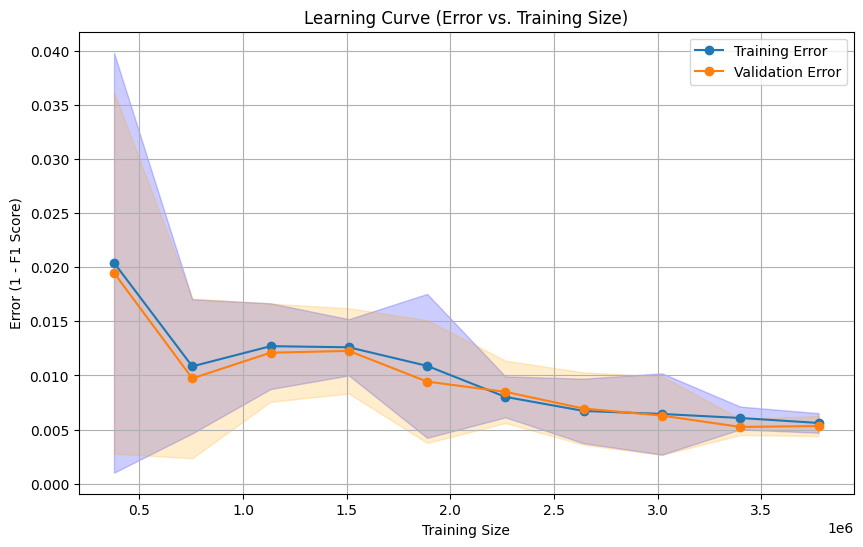

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator=random_search.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="f1",
)

# Compute mean and standard deviation of errors
train_errors = 1 - np.mean(train_scores, axis=1)
test_errors = 1 - np.mean(test_scores, axis=1)
train_errors_std = np.std(train_scores, axis=1)
test_errors_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label="Training Error", marker='o')
plt.fill_between(
    train_sizes,
    train_errors - train_errors_std,
    train_errors + train_errors_std,
    alpha=0.2,
    color="blue",
)

plt.plot(train_sizes, test_errors, label="Validation Error", marker='o')
plt.fill_between(
    train_sizes,
    test_errors - test_errors_std,
    test_errors + test_errors_std,
    alpha=0.2,
    color="orange",
)

plt.title("Learning Curve (Error vs. Training Size)")
plt.xlabel("Training Size")
plt.ylabel("Error (1 - F1 Score)")
plt.legend(loc="best")
plt.grid()
plt.show()


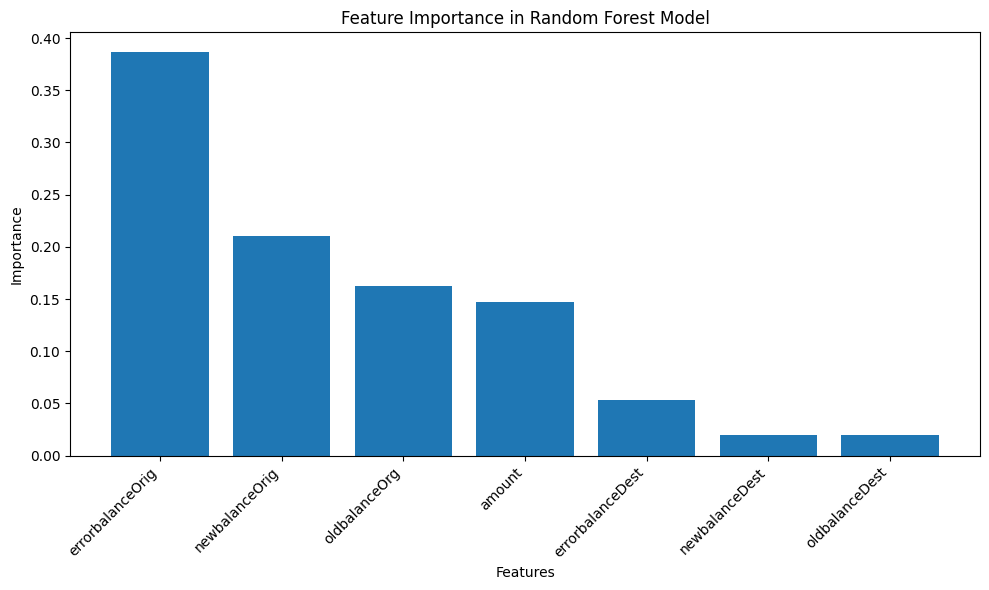


Feature Importances:
         feature  importance
errorbalanceOrig    0.386132
  newbalanceOrig    0.210591
   oldbalanceOrg    0.162828
          amount    0.147096
errorbalanceDest    0.053315
  newbalanceDest    0.020096
  oldbalanceDest    0.019941


In [24]:
# Get the best estimator from your random search
rf_model = random_search.best_estimator_

# Get feature importances
importances = rf_model.feature_importances_

# Assuming you have your feature names in a list called feature_names
# If you don't, you can create it from your X_test_scaled columns
feature_names = X_test.columns 

# Create a DataFrame for better visualization
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame of features and their importance scores
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), feature_importance_df['importance'])
plt.xticks(range(len(importances)), feature_importance_df['feature'], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

# Print numerical values
print("\nFeature Importances:")
print(feature_importance_df.to_string(index=False))

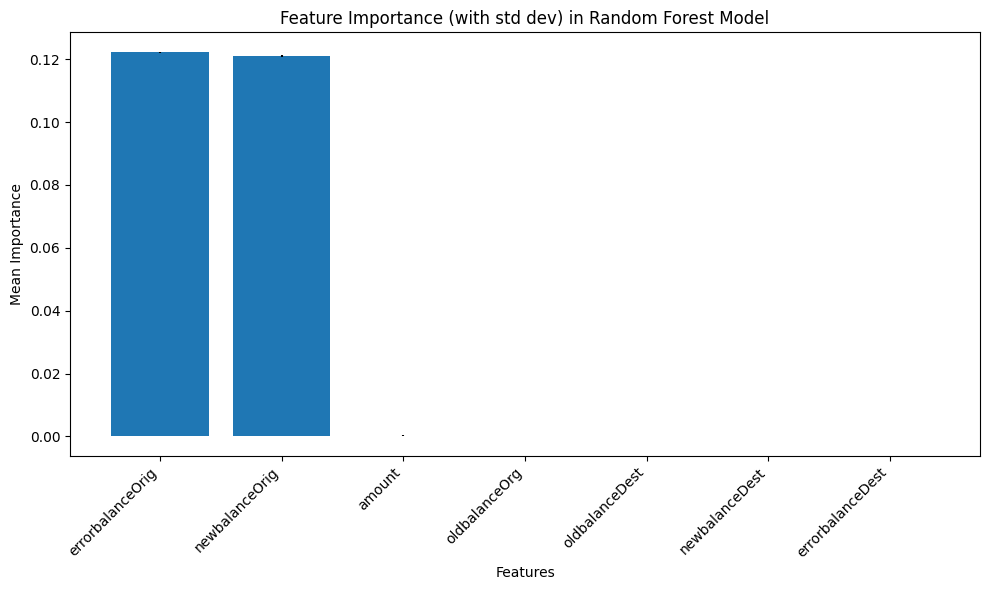


Feature Importances with Standard Deviation:
         feature  importance_mean  importance_std
errorbalanceOrig     1.222313e-01        0.000203
  newbalanceOrig     1.209986e-01        0.000252
          amount     2.710541e-04        0.000010
   oldbalanceOrg     1.016850e-05        0.000006
  oldbalanceDest     5.190172e-06        0.000002
  newbalanceDest     4.236875e-07        0.000002
errorbalanceDest    -2.648047e-06        0.000003


In [25]:
from sklearn.inspection import permutation_importance
import numpy as np

# Calculate permutation importance
result = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Create DataFrame with mean importance and standard deviation
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by mean importance
feature_importance_df = feature_importance_df.sort_values('importance_mean', ascending=False)

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(range(len(result.importances_mean)), 
        feature_importance_df['importance_mean'],
        yerr=feature_importance_df['importance_std'],
        align='center')
plt.xticks(range(len(result.importances_mean)), 
          feature_importance_df['feature'], 
          rotation=45, 
          ha='right')
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Feature Importance (with std dev) in Random Forest Model')
plt.tight_layout()
plt.show()

# Print numerical values
print("\nFeature Importances with Standard Deviation:")
print(feature_importance_df.to_string(index=False))

In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation using F1-score as the metric
cv_scores = cross_val_score(random_search.best_estimator_, X, y, cv=cv, scoring='f1', n_jobs=-1)

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV F1-score: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV F1-score: {cv_scores.std():.4f}")

Cross-validation scores: [0.99671053 0.99753695 0.99712526 0.99835796 0.9979483 ]
Average CV F1-score: 0.9975
Standard deviation of CV F1-score: 0.0006


In [4]:
from abc import ABC, abstractmethod
from typing import Union, List, Tuple, Any
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Step 1: Define Abstract Base Class for Scaling Strategy
class ScalingStrategy(ABC):
    @abstractmethod
    def fit(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series], 
            y: Union[List, pd.Series, np.ndarray, None] = None) -> Any:
        """
        Abstract method to fit the data using the scaler
        
        Params:
            X: Training features
            y: Target feature (optional)
            
        Returns:
            Fitted scaler instance
        """
        pass
    
    @abstractmethod
    def fit_transform(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
                     y: Union[List, pd.Series, np.ndarray, None] = None) -> Tuple[Any, np.ndarray, Union[np.ndarray, None]]:
        """
        Abstract method to fit and transform the data using the scaler
        
        Params:
            X: Training features
            y: Target feature (optional)
            
        Returns:
            Tuple containing (fitted scaler instance, transformed X, transformed y)
        """
        pass

# Step 2: Define Concrete Strategies for Scaling
class StandardScalingStrategy(ScalingStrategy):
    def __init__(self):
        """
        Instantiates the Standard Scaling Strategy
        """
        self.scaler = StandardScaler()
    
    def fit(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
            y: Union[List, pd.Series, np.ndarray, None] = None) -> StandardScaler:
        """
        Fits the data with Standard Scaler
        
        Params:
            X: Training features
            y: Target feature (optional)
            
        Returns:
            Fitted StandardScaler instance
        """
        X_array = np.array(X) if not isinstance(X, np.ndarray) else X
        self.scaler.fit(X_array.reshape(-1, 1) if X_array.ndim == 1 else X_array)
        return self.scaler
    
    def fit_transform(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
                     y: Union[List, pd.Series, np.ndarray, None] = None) -> Tuple[StandardScaler, np.ndarray, Union[np.ndarray, None]]:
        """
        Fits and transforms the data with Standard Scaler
        
        Params:
            X: Training features
            y: Target feature (optional)
            
        Returns:
            Tuple containing (fitted StandardScaler, transformed X, transformed y)
        """
        X_array = np.array(X) if not isinstance(X, np.ndarray) else X
        X_transformed = self.scaler.fit_transform(X_array.reshape(-1, 1) if X_array.ndim == 1 else X_array)
        
        y_transformed = None
        if y is not None:
            y_array = np.array(y) if not isinstance(y, np.ndarray) else y
            y_transformed = self.scaler.transform(y_array.reshape(-1, 1) if y_array.ndim == 1 else y_array)
        
        return self.scaler, X_transformed, y_transformed

class MinMaxScalingStrategy(ScalingStrategy):
    def __init__(self):
        """
        Instantiates the MinMax Scaling Strategy
        """
        self.scaler = MinMaxScaler()
    
    def fit(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
            y: Union[List, pd.Series, np.ndarray, None] = None) -> MinMaxScaler:
        """
        Fits the data with MinMax Scaler
        
        Params:
            X: Training features
            y: Target feature (optional)
            
        Returns:
            Fitted MinMaxScaler instance
        """
        X_array = np.array(X) if not isinstance(X, np.ndarray) else X
        self.scaler.fit(X_array.reshape(-1, 1) if X_array.ndim == 1 else X_array)
        return self.scaler
    
    def fit_transform(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
                     y: Union[List, pd.Series, np.ndarray, None] = None) -> Tuple[MinMaxScaler, np.ndarray, Union[np.ndarray, None]]:
        """
        Fits and transforms the data with MinMax Scaler
        
        Params:
            X: Training features
            y: Target feature (optional)
            
        Returns:
            Tuple containing (fitted MinMaxScaler, transformed X, transformed y)
        """
        X_array = np.array(X) if not isinstance(X, np.ndarray) else X
        X_transformed = self.scaler.fit_transform(X_array.reshape(-1, 1) if X_array.ndim == 1 else X_array)
        
        y_transformed = None
        if y is not None:
            y_array = np.array(y) if not isinstance(y, np.ndarray) else y
            y_transformed = self.scaler.transform(y_array.reshape(-1, 1) if y_array.ndim == 1 else y_array)
        
        return self.scaler, X_transformed, y_transformed

# Step 3: Define Context Class for Scalers
class ScalingStrategyHandler:
    def __init__(self, strategy: ScalingStrategy):
        """
        Initiates the scaling strategy
        
        Params:
            strategy: A concrete implementation of ScalingStrategy
        """
        self.strategy = strategy
    
    def set_strategy(self, strategy: ScalingStrategy) -> None:
        """
        Sets the scaling strategy for scaling the data
        
        Params:
            strategy: A concrete implementation of ScalingStrategy
        """
        self.strategy = strategy
    
    def scale_data(self, X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
                   y: Union[List, pd.Series, np.ndarray, None] = None,
                   transform_only: bool = False) -> Union[Any, Tuple[Any, np.ndarray, Union[np.ndarray, None]]]:
        """
        Handles the scaling method
        
        Params:
            X: Training features
            y: Target feature (optional)
            transform_only: If True, only fits the scaler. If False, fits and transforms the data.
            
        Returns:
            Either the fitted scaler (if transform_only=True) or
            a tuple of (fitted scaler, transformed X, transformed y)
        """
        if transform_only:
            return self.strategy.fit(X, y)
        return self.strategy.fit_transform(X, y)

In [5]:
from abc import ABC, abstractmethod
from typing import Union, List, Tuple, Optional, Dict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Define Abstract Base Class for Data Split Strategy
class DataSplitter(ABC):
    @abstractmethod
    def split(self,
             X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
             y: Optional[Union[List, pd.Series, np.ndarray]] = None,
             **kwargs) -> Dict[str, Union[np.ndarray, pd.DataFrame]]:
        """
        Abstract method to split the data into Training and Testing sets
        
        Args:
            X: Input features
            y: Target variable (optional)
            **kwargs: Additional parameters for splitting
            
        Returns:
            Dictionary containing split datasets
        """
        pass

# Step 2: Define concrete strategy for train-test split
class TrainTestSplitStrategy(DataSplitter):
    def __init__(self):
        """
        Initialize the Train-Test Split Strategy
        """
        pass
    
    def _validate_inputs(self, X, y, test_size):
        """
        Validate input parameters
        
        Args:
            X: Input features
            y: Target variable
            test_size: Proportion of test set
            
        Raises:
            ValueError: If inputs are invalid
        """
        if test_size <= 0 or test_size >= 1:
            raise ValueError("test_size must be between 0 and 1")
        
        if y is not None and len(X) != len(y):
            raise ValueError("X and y must have the same length")
    
    def _convert_to_array(self, data):
        """
        Convert input data to numpy array if needed
        
        Args:
            data: Input data
            
        Returns:
            numpy array
        """
        if isinstance(data, (pd.DataFrame, pd.Series)):
            return data.values
        elif isinstance(data, list):
            return np.array(data)
        return data
    
    def split(self,
             X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
             y: Optional[Union[List, pd.Series, np.ndarray]] = None,
             test_size: float = 0.2,
             random_state: Optional[int] = None,
             shuffle: bool = True,
             stratify: Optional[Union[List, np.ndarray]] = None) -> Dict[str, Union[np.ndarray, pd.DataFrame]]:
        """
        Split the data into Training and Testing sets
        
        Args:
            X: Input features
            y: Target variable (optional)
            test_size: Proportion of test set
            random_state: Random seed for reproducibility
            shuffle: Whether to shuffle the data
            stratify: Array for stratified split
            
        Returns:
            Dictionary containing train and test splits
        """
        # Validate inputs
        self._validate_inputs(X, y, test_size)
        
        # Convert inputs to arrays if needed
        X_array = self._convert_to_array(X)
        y_array = self._convert_to_array(y) if y is not None else None
        
        # Perform split
        split_data = train_test_split(
            X_array,
            y_array,
            test_size=test_size,
            random_state=random_state,
            shuffle=shuffle,
            stratify=stratify
        )
        
        # Create return dictionary
        if y is None:
            X_train, X_test = split_data
            result = {
                'X_train': X_train,
                'X_test': X_test
            }
        else:
            X_train, X_test, y_train, y_test = split_data
            result = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
        
        # Add split info
        result['split_info'] = {
            'train_size': len(X_train),
            'test_size': len(X_test),
            'train_ratio': 1 - test_size,
            'test_ratio': test_size
        }
        
        return result

# Step 3: Define context class for data splitting
class BuildTrainTestSplit:
    def __init__(self, strategy: DataSplitter):
        """
        Initialize the data split handler
        
        Args:
            strategy: A concrete implementation of DataSplitter
        """
        self.strategy = strategy
    
    def set_strategy(self, strategy: DataSplitter) -> None:
        """
        Set the data splitting strategy
        
        Args:
            strategy: A concrete implementation of DataSplitter
        """
        self.strategy = strategy
    
    def split_data(self,
                  X: Union[List, pd.DataFrame, np.ndarray, pd.Series],
                  y: Optional[Union[List, pd.Series, np.ndarray]] = None,
                  **kwargs) -> Dict[str, Union[np.ndarray, pd.DataFrame]]:
        """
        Split the data using the current strategy
        
        Args:
            X: Input features
            y: Target variable (optional)
            **kwargs: Additional parameters for splitting
            
        Returns:
            Dictionary containing split datasets
        """
        return self.strategy.split(X, y, **kwargs)

In [6]:
from abc import ABC, abstractmethod
from typing import Union, Optional, Dict, Any, Tuple
import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Step 1: Define Abstract Base Class for Model Classifier
class ModelClassifier(ABC):
    @abstractmethod
    def build_classifier(self, 
                        X: Union[np.ndarray, pd.DataFrame], 
                        y: Union[np.ndarray, pd.Series],
                        **kwargs) -> ClassifierMixin:
        """
        Abstract method to build the classifier
        
        Args:
            X: Input training features
            y: Input labels
            **kwargs: Additional parameters for the classifier
            
        Returns:
            A fitted classifier instance
        """
        pass

    @abstractmethod
    def evaluate(self, 
                X: Union[np.ndarray, pd.DataFrame], 
                y: Union[np.ndarray, pd.Series]) -> Dict[str, Any]:
        """
        Abstract method to evaluate the classifier
        
        Args:
            X: Input test features
            y: Input test labels
            
        Returns:
            Dictionary containing evaluation metrics
        """
        pass

# Step 2: Define Concrete Product Classes
class RandomForestModel(ModelClassifier):
    def __init__(self):
        """
        Initialize the RandomForestClassifier model
        """
        self.model: Optional[RandomForestClassifier] = None
        
    def build_classifier(self, 
                        X: Union[np.ndarray, pd.DataFrame], 
                        y: Union[np.ndarray, pd.Series],
                        **kwargs) -> RandomForestClassifier:
        """
        Build and fit the Random Forest Classifier with given parameters
        
        Args:
            X: Input training features
            y: Input labels
            **kwargs: Parameters for RandomForestClassifier
            
        Returns:
            Fitted RandomForestClassifier instance
        """
        # Convert inputs to numpy arrays if needed
        X_array = np.array(X) if not isinstance(X, np.ndarray) else X
        y_array = np.array(y) if not isinstance(y, np.ndarray) else y
        
        # Create and fit the model
        self.model = RandomForestClassifier(**kwargs)
        self.model.fit(X_array, y_array)
        
        return self.model
    
    def evaluate(self, 
                X: Union[np.ndarray, pd.DataFrame], 
                y: Union[np.ndarray, pd.Series]) -> Dict[str, Any]:
        """
        Evaluate the Random Forest Classifier
        
        Args:
            X: Input test features
            y: Input test labels
            
        Returns:
            Dictionary containing evaluation metrics
        """
        if self.model is None:
            raise ValueError("Model not fitted. Call build_classifier first.")
        
        # Convert inputs to numpy arrays if needed
        X_array = np.array(X) if not isinstance(X, np.ndarray) else X
        y_array = np.array(y) if not isinstance(y, np.ndarray) else y
        
        # Make predictions
        y_pred = self.model.predict(X_array)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_array, y_pred),
            'classification_report': classification_report(y_array, y_pred),
            'F1-score': f1_score(y_array, y_pred),
            'feature_importance': dict(zip(range(X_array.shape[1]), 
                                        self.model.feature_importances_))
        }
        
        return metrics

# Step 3: Define Context Class
class ClassifierStrategy:
    def __init__(self, strategy: ModelClassifier):
        """
        Initialize the Classifier Strategy
        
        Args:
            strategy: A concrete implementation of ModelClassifier
        """
        self.strategy = strategy
        
    def set_strategy(self, strategy: ModelClassifier) -> None:
        """
        Set model strategy for building the model
        
        Args:
            strategy: A concrete implementation of ModelClassifier
        """
        self.strategy = strategy
        
    def _split_data(self, 
                    X: Union[np.ndarray, pd.DataFrame],
                    y: Union[np.ndarray, pd.Series],
                    test_size: float = 0.2,
                    random_state: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Private method to split the data into training and test sets
        
        Args:
            X: Input features
            y: Input labels
            test_size: Proportion of dataset to include in the test split
            random_state: Random state for reproducibility
            
        Returns:
            Tuple containing (X_train, X_test, y_train, y_test)
        """
        return train_test_split(X, y, test_size=test_size, random_state=random_state)
        
    def build_and_evaluate(self, 
                          X: Union[np.ndarray, pd.DataFrame],
                          y: Union[np.ndarray, pd.Series],
                          split_data: bool = True,
                          test_size: float = 0.2,
                          random_state: int = 42,
                          **kwargs) -> Dict[str, Any]:
        """
        Build and evaluate the classifier
        
        Args:
            X: Input features
            y: Input labels
            split_data: Whether to split the data into train and test sets
            test_size: Proportion of dataset to include in the test split
            random_state: Random state for reproducibility
            **kwargs: Additional parameters for the classifier
            
        Returns:
            Dictionary containing model and evaluation metrics
        """
        if split_data:
            # Split the data if required
            X_train, X_test, y_train, y_test = self._split_data(
                X, y, test_size=test_size, random_state=random_state
            )
        else:
            # Use the same data for training and testing if splitting is not required
            X_train, X_test = X, X
            y_train, y_test = y, y
        
        # Build the classifier
        model = self.strategy.build_classifier(X_train, y_train, **kwargs)
        
        # Evaluate the classifier
        evaluation_metrics = self.strategy.evaluate(X_test, y_test)
        
        return {
            'model': model,
            'metrics': evaluation_metrics,
            'data': {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            } if split_data else {
                'X': X,
                'y': y
            }
        }

In [138]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation using F1-score as the metric
cv_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring='f1', n_jobs=-1)

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV F1-score: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV F1-score: {cv_scores.std():.4f}")


Cross-validation scores: [0.84181055 0.85171455 0.83858998 0.85779607 0.83372365]
Average CV F1-score: 0.8447
Standard deviation of CV F1-score: 0.0088


In [126]:
X_train_scaled.shape, y_train.shape

((1644428, 8), (1315542,))

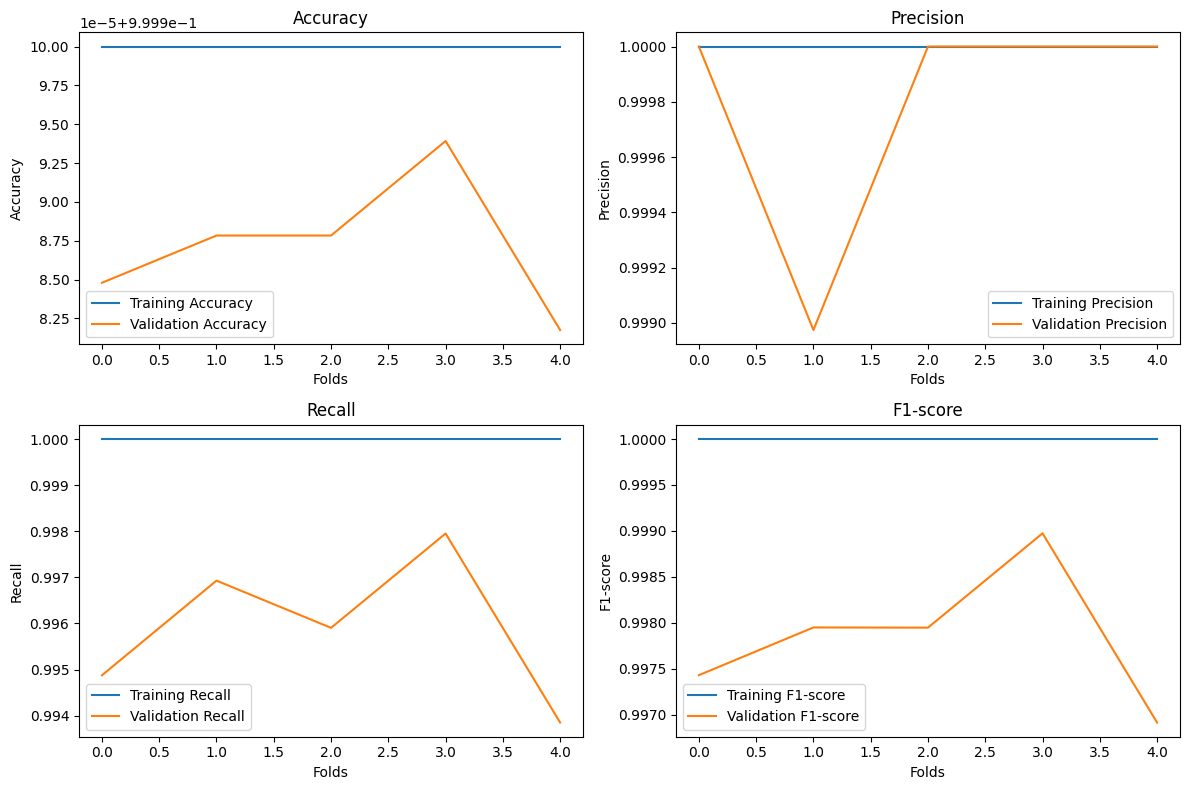

Average Training Accuracy: 1.0000
Average Validation Accuracy: 1.0000
Average Training Precision: 1.0000
Average Validation Precision: 0.9998
Average Training Recall: 1.0000
Average Validation Recall: 0.9959
Average Training F1-score: 1.0000
Average Validation F1-score: 0.9978


In [131]:

# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure no leakage during preprocessing by fitting only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only
X_test_scaled = scaler.transform(X_test) 


# Convert the NumPy arrays to pandas DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled)
y_train_df = pd.Series(y_train)

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the metrics
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

# Cross-validation loop
for train_index, val_index in skf.split(X_train_scaled, y_train):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train_scaled_df.iloc[train_index], X_train_scaled_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train_df.iloc[train_index], y_train_df.iloc[val_index]
    
    # Train the Random Forest model
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=8)
    rf_classifier.fit(X_train_fold, y_train_fold)
    
    # Training metrics
    y_train_pred = rf_classifier.predict(X_train_fold)
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_precisions.append(precision_score(y_train_fold, y_train_pred))
    train_recalls.append(recall_score(y_train_fold, y_train_pred))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))

    # Validation metrics
    y_val_pred = rf_classifier.predict(X_val_fold)
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_precisions.append(precision_score(y_val_fold, y_val_pred))
    val_recalls.append(recall_score(y_val_fold, y_val_pred))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Plot the metrics
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Precision plot
plt.subplot(2, 2, 2)
plt.plot(range(len(train_precisions)), train_precisions, label='Training Precision')
plt.plot(range(len(val_precisions)), val_precisions, label='Validation Precision')
plt.xlabel('Folds')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

# Recall plot
plt.subplot(2, 2, 3)
plt.plot(range(len(train_recalls)), train_recalls, label='Training Recall')
plt.plot(range(len(val_recalls)), val_recalls, label='Validation Recall')
plt.xlabel('Folds')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

# F1-score plot
plt.subplot(2, 2, 4)
plt.plot(range(len(train_f1_scores)), train_f1_scores, label='Training F1-score')
plt.plot(range(len(val_f1_scores)), val_f1_scores, label='Validation F1-score')
plt.xlabel('Folds')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1-score')

plt.tight_layout()
plt.show()

# Calculate average metrics across all folds
print(f"Average Training Accuracy: {sum(train_accuracies)/len(train_accuracies):.4f}")
print(f"Average Validation Accuracy: {sum(val_accuracies)/len(val_accuracies):.4f}")
print(f"Average Training Precision: {sum(train_precisions)/len(train_precisions):.4f}")
print(f"Average Validation Precision: {sum(val_precisions)/len(val_precisions):.4f}")
print(f"Average Training Recall: {sum(train_recalls)/len(train_recalls):.4f}")
print(f"Average Validation Recall: {sum(val_recalls)/len(val_recalls):.4f}")
print(f"Average Training F1-score: {sum(train_f1_scores)/len(train_f1_scores):.4f}")
print(f"Average Validation F1-score: {sum(val_f1_scores)/len(val_f1_scores):.4f}")
